In [49]:
import numpy as np
import torch.optim as optim
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical

from tqdm import tqdm

import matplotlib.pyplot as plt

import env


In [50]:
cuda = False

In [51]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Actor Critic on LunarLander enviorment

In [52]:
class Actor(nn.Module):
    def __init__(self):
        super(Actor, self).__init__()
        self.linear1 = nn.Linear(8, 128)
        self.linear2 = nn.Linear(128, 4)

    def forward(self, state):
        if cuda == False: 
            state = torch.from_numpy(state).float()
        output_1 = F.relu(self.linear1(state))
        output_2 = self.linear2(output_1)

        distribution = Categorical(F.softmax(output_2, dim=-1))

        return output_1, distribution

class Critic(nn.Module):
    def __init__(self, ):
        super(Critic, self).__init__()
        self.linear1 = nn.Linear(128, 1)

    def forward(self, state):
        value = self.linear1(state)

        return value

class ActorCritic(nn.Module):
    def __init__(self, actor, critic):
        super(ActorCritic, self).__init__()
        self.actor = actor
        self.critic = critic

        self.logprobs = []
        self.state_values = []
        self.rewards = []

    def forward(self, state):
        state, distribution = self.actor(state)
        action = distribution.sample()
        
        state_value = self.critic(state)
        
        self.logprobs.append(distribution.log_prob(action))
        self.state_values.append(state_value)
        
        return action.item()
    
    def calculateLoss(self, gamma=0.99):
        # calculating discounted rewards:
        rewards = []
        dis_reward = 0
        for reward in self.rewards[::-1]:
            dis_reward = reward + gamma * dis_reward
            rewards.insert(0, dis_reward)
                
        # normalizing the rewards:
        rewards = torch.tensor(rewards)
        rewards = (rewards - rewards.mean()) / (rewards.std())
        
        loss = 0
        for logprob, value, reward in zip(self.logprobs, self.state_values, rewards):
            advantage = reward  - value.item()
            action_loss = -logprob * advantage
            if cuda: reward = reward.cuda()
            value_loss = F.smooth_l1_loss(value, reward)
            loss += (action_loss + value_loss)   
        return loss

    def clearMemory(self):
        del self.logprobs[:]
        del self.state_values[:]
        del self.rewards[:]

In [53]:
def train(env, agent, optimizer, episodes = 2000, gamma = 0.99, is_render = False):
    avg_rewards,  episode_rewards= [], []
    
    for episode in  range(episodes):
        state = env.reset(seed = 42)
        total_reward = 0

        for i in range(10000):
            if cuda: state = torch.FloatTensor(state).to(device)
            action = agent(state)
            state, reward, done, _ = env.step(action)
            agent.rewards.append(reward)
            total_reward += reward
            if is_render and episode % 1000 == 0:
                env.render()
            if done:
                episode_rewards.append(total_reward)
                break

        # Updating the policy :
        optimizer.zero_grad()
        loss = agent.calculateLoss(gamma)
        loss.backward()
        optimizer.step()
        agent.clearMemory()
        
        if episode >= 100:
          avg_rewards.append(np.mean(episode_rewards[-100:]))
          if avg_rewards[-1] >= 200:
            print("Solved on episode ",episode)
            return episode_rewards, avg_rewards

        if episode % 100 == 0 and episode >= 100:
            print("e: %d, episode reward: %.2f, avg reward %.2f" % (episode, episode_rewards[-1], avg_rewards[-1]))

    return episode_rewards, avg_rewards

In [54]:
# enviorment parameter setting
random_seed = 42
torch.manual_seed(random_seed)

enviorment = env.LunarLander(gravity=-10.0)

In [55]:
# agent parameter setting
lr = 0.02
betas = (0.9, 0.999)

actor = Actor()
critic = Critic()
agent = ActorCritic(actor, critic)

optimizer = optim.Adam(agent.parameters(), lr=lr, betas=betas)

In [56]:
if (cuda):
    actor = actor.cuda()
    critic = critic.cuda()
    agent = agent.cuda()

In [57]:
rew1, avg1 = train(enviorment, agent, optimizer)

C:\Users\55366\AppData\Local\Temp\ipykernel_3808\647289630.py:65: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.smooth_l1_loss(value, reward)


e: 100, episode reward: -80.81, avg reward -251.06
e: 200, episode reward: -374.34, avg reward -208.23
e: 300, episode reward: -44.64, avg reward -103.94
e: 400, episode reward: -122.67, avg reward -50.92
e: 500, episode reward: -192.55, avg reward -197.06
e: 600, episode reward: 15.23, avg reward 8.21
e: 700, episode reward: 194.61, avg reward 12.42
e: 800, episode reward: 273.26, avg reward 11.15
e: 900, episode reward: 143.61, avg reward 29.48
e: 1000, episode reward: 184.44, avg reward 13.52
e: 1100, episode reward: 28.95, avg reward 95.07
Solved on episode  1195


Text(0.5, 1.0, 'LunarLander env (average reward)')

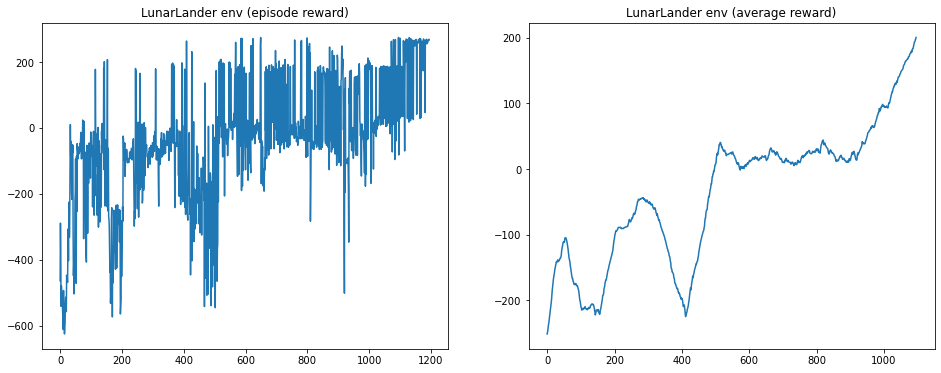

In [58]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(16, 6))
ax1.plot(rew1)
ax1.set_title("LunarLander env (episode reward)")
ax2.plot(avg1)
ax2.set_title("LunarLander env (average reward)")

In [59]:
torch.save(actor, "./model_weight/actor")
torch.save(critic, "./model_weight/critic")

## Enviorment 2: 
Suppose there is another planent and his gravity is twice that of the moon, so each time we use a main engine or a side engine, it will has half effect in y-direcion compared to moon.

In [60]:
random_seed = 42
torch.manual_seed(random_seed)

env_wind = env.LunarLander(gravity=-5.0, enable_wind=True, wind_power = 15.0)

In [61]:
actor_wind = Actor()
critic_wind = Critic()

agent_env2 = ActorCritic(actor_wind, critic_wind)

lr = 0.02
betas = (0.9, 0.999)
optimizer = optim.Adam(agent_env2.parameters(), lr=lr, betas=betas)

rew_env2, avg_env2 = train(env_wind, agent_env2, optimizer, episodes = 2500)

C:\Users\55366\AppData\Local\Temp\ipykernel_3808\647289630.py:65: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.smooth_l1_loss(value, reward)


e: 100, episode reward: -276.46, avg reward -461.59
e: 200, episode reward: -105.52, avg reward -107.29
e: 300, episode reward: -273.06, avg reward -224.59
e: 400, episode reward: -230.49, avg reward -80.47
e: 500, episode reward: -477.66, avg reward -317.90
e: 600, episode reward: -152.40, avg reward -202.17
e: 700, episode reward: -172.99, avg reward -195.60
e: 800, episode reward: 283.53, avg reward -69.46
e: 900, episode reward: -117.93, avg reward -84.13
e: 1000, episode reward: -138.43, avg reward -48.11
e: 1100, episode reward: 208.11, avg reward -14.33
e: 1200, episode reward: -473.28, avg reward -69.05
e: 1300, episode reward: 202.17, avg reward -12.74
e: 1400, episode reward: -141.15, avg reward -52.67
e: 1500, episode reward: 11.52, avg reward -15.26
e: 1600, episode reward: -193.02, avg reward -63.13
e: 1700, episode reward: 138.50, avg reward -35.87
e: 1800, episode reward: -148.88, avg reward 51.25
e: 1900, episode reward: 197.88, avg reward 65.81
e: 2000, episode reward:

Text(0.5, 1.0, 'Wind (average reward)')

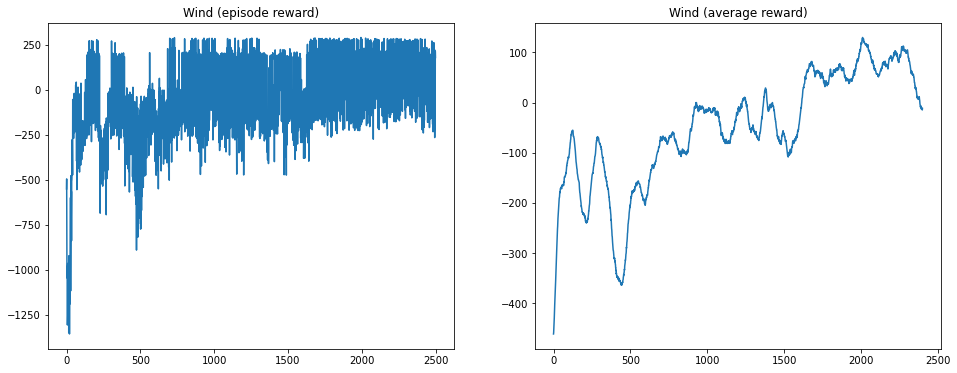

In [62]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(16, 6))

ax1.plot(rew_env2)
ax1.set_title("Wind (episode reward)")
ax2.plot(avg_env2)
ax2.set_title("Wind (average reward)")

In [63]:
torch.save(actor_wind, "./model_weight/actor_wind")
torch.save(critic_wind, "./model_weight/critic_wind")

## Train on second enviorment using first enviorment's weight

In [64]:
actor = torch.load('./model_weight/actor')
critic = torch.load('./model_weight/critic')

agent_combined = ActorCritic(actor, critic)
optimizer = optim.Adam(agent_combined.parameters(), lr=lr, betas=betas)
rew3, avg3 = train(env_wind, agent_combined, optimizer, episodes = 2000)

C:\Users\55366\AppData\Local\Temp\ipykernel_3808\647289630.py:65: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.smooth_l1_loss(value, reward)


e: 100, episode reward: 2.61, avg reward 38.98
e: 200, episode reward: 190.74, avg reward 112.32
e: 300, episode reward: 178.65, avg reward 179.10
e: 400, episode reward: 258.44, avg reward 138.40
e: 500, episode reward: -65.63, avg reward 74.20
e: 600, episode reward: 222.44, avg reward 124.66
e: 700, episode reward: -83.55, avg reward 9.13
e: 800, episode reward: -141.39, avg reward -12.80
e: 900, episode reward: 177.54, avg reward 34.25
e: 1000, episode reward: -107.76, avg reward 44.36
e: 1100, episode reward: 194.43, avg reward 85.97
e: 1200, episode reward: -14.93, avg reward 103.90
e: 1300, episode reward: -14.18, avg reward 141.09
e: 1400, episode reward: 204.53, avg reward 185.00
e: 1500, episode reward: -26.86, avg reward 102.50
e: 1600, episode reward: 173.36, avg reward 87.91
e: 1700, episode reward: 237.47, avg reward 96.89
e: 1800, episode reward: 273.13, avg reward 128.33
e: 1900, episode reward: 168.18, avg reward 185.82


Text(0.5, 1.0, "Use env1's weight on env2 (average reward)")

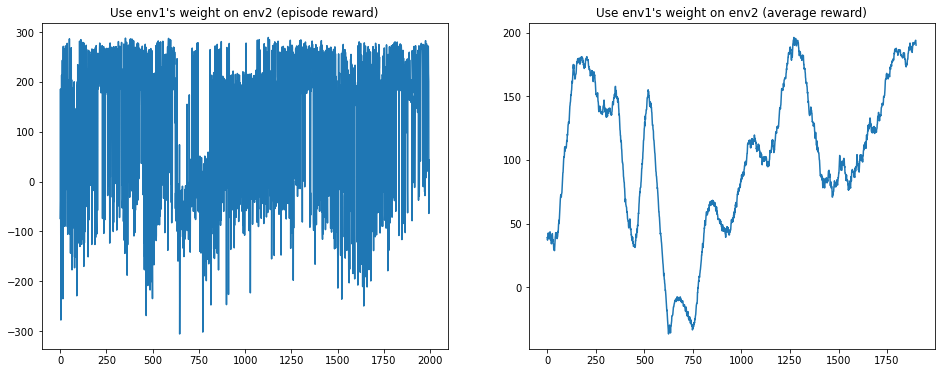

In [65]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(16, 6))

ax1.plot(rew3)
ax1.set_title("Use env1's weight on env2 (episode reward)")

ax2.plot(avg3)
ax2.set_title("Use env1's weight on env2 (average reward)")

## Domain Transfer

In [75]:
class Trail(nn.Module):
    def __init__(self, teacher, critic):
        super(Trail, self).__init__()
        self.t = teacher

        self.affine_actor = nn.Linear(8, 8)
        self.critic = critic
        self.logprobs = []
        self.state_values = []
        self.rewards = []
    
    def forward(self, state):
        state = torch.from_numpy(state).float()
        state = F.relu(self.affine_actor(state))
        state = state.detach().numpy()
        state, distribution = self.t(state)

        action = distribution.sample()
        
        state_value = self.critic(state)
        
        self.logprobs.append(distribution.log_prob(action))
        self.state_values.append(state_value)
        
        return action.item()

    def calculateLoss(self, gamma=0.99):
        # calculating discounted rewards:
        rewards = []
        dis_reward = 0
        for reward in self.rewards[::-1]:
            dis_reward = reward + gamma * dis_reward
            rewards.insert(0, dis_reward)
                
        # normalizing the rewards:
        rewards = torch.tensor(rewards)
        rewards = (rewards - rewards.mean()) / (rewards.std())
        
        loss = 0
        for logprob, value, reward in zip(self.logprobs, self.state_values, rewards):
            advantage = reward  - value.item()
            action_loss = -logprob * advantage
            if cuda: reward = reward.cuda()
            value_loss = F.smooth_l1_loss(value, reward)
            loss += (action_loss + value_loss)   
        return loss

    def clearMemory(self):
        del self.logprobs[:]
        del self.state_values[:]
        del self.rewards[:]

In [76]:
actor = torch.load('./model_weight/actor')
critic = torch.load('./model_weight/critic')

agent_trail = Trail(actor, critic)
optimizer = optim.Adam(agent_trail.parameters(), lr=lr, betas=betas)
rew6, avg6 = train(env_wind, agent_trail, optimizer, episodes = 2000)

C:\Users\55366\AppData\Local\Temp\ipykernel_3808\3463294109.py:44: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.smooth_l1_loss(value, reward)


e: 100, episode reward: -69.08, avg reward -128.81
e: 200, episode reward: -259.17, avg reward -137.76
e: 300, episode reward: -62.17, avg reward -184.55
e: 400, episode reward: -30.16, avg reward -195.34
e: 500, episode reward: -110.69, avg reward -317.11
e: 600, episode reward: -324.74, avg reward -152.23
e: 700, episode reward: -275.22, avg reward -222.41
e: 800, episode reward: -7.44, avg reward -111.65
e: 900, episode reward: -50.98, avg reward -98.67
e: 1000, episode reward: -191.69, avg reward -266.40
e: 1100, episode reward: -298.34, avg reward -197.68
e: 1200, episode reward: -150.39, avg reward -134.57
e: 1300, episode reward: -175.01, avg reward -100.87
e: 1400, episode reward: -38.78, avg reward -112.81
e: 1500, episode reward: 21.69, avg reward -148.27
e: 1600, episode reward: -63.70, avg reward -110.21
e: 1700, episode reward: -123.19, avg reward -83.95
e: 1800, episode reward: -196.51, avg reward -149.34
e: 1900, episode reward: -187.46, avg reward -246.40


In [77]:
class Trail_2(nn.molule):
    def __init__(self, teacher, critic):
        super(Trail, self).__init__()
        self.t = teacher

        self.affine_actor = nn.Linear(8, 8)
        self.affine_critic = nn.Linear(128, 128)

        self.critic = critic
        self.logprobs = []
        self.state_values = []
        self.rewards = []
    
    def forward(self, state):
        state = F.relu(self.affine_actor(state))

        state, distribution = self.t(state)

        action = distribution.sample()

        state = F.relu(self.affine_critic(state))
        
        state_value = self.critic(state)
        
        self.logprobs.append(distribution.log_prob(action))
        self.state_values.append(state_value)
        
        return action.item()

    def calculateLoss(self, gamma=0.99):
        # calculating discounted rewards:
        rewards = []
        dis_reward = 0
        for reward in self.rewards[::-1]:
            dis_reward = reward + gamma * dis_reward
            rewards.insert(0, dis_reward)
                
        # normalizing the rewards:
        rewards = torch.tensor(rewards)
        rewards = (rewards - rewards.mean()) / (rewards.std())
        
        loss = 0
        for logprob, value, reward in zip(self.logprobs, self.state_values, rewards):
            advantage = reward  - value.item()
            action_loss = -logprob * advantage
            if cuda: reward = reward.cuda()
            value_loss = F.smooth_l1_loss(value, reward)
            loss += (action_loss + value_loss)   
        return loss

    def clearMemory(self):
        del self.logprobs[:]
        del self.state_values[:]
        del self.rewards[:]

AttributeError: module 'torch.nn' has no attribute 'molule'

In [ ]:
actor = torch.load('./model_weight/actor')
critic = torch.load('./model_weight/critic')

agent_trail2 = Trail_2(actor, critic)
optimizer = optim.Adam(agent_trail2.parameters(), lr=lr, betas=betas)
rew4, avg4 = train(env_wind, agent_trail2, optimizer, episodes = 2000)

## Second Attempt

In [78]:
class TNet(nn.Module):
    def __init__(self, teacher_1, teacher_2):
        super(TNet, self).__init__()
        self.t1 = teacher_1
        self.t2 = teacher_2

        self.affine = nn.Linear(256, 128)
        self.action_layer = nn.Linear(128, 4)
        self.value_layer = nn.Linear(128, 1)

        self.logprobs = []
        self.state_values = []
        self.rewards = []

    def forward(self, state):
        output_1, distribution_1 = self.t1(state)
        output_2, distribution_2 = self.t2(state)

        out = torch.cat((output_1, output_2))
        
        state = self.affine(out)

        action_prob = F.softmax(self.action_layer(state), dim=-1)
        state_value =  self.value_layer(state)

        distribution = Categorical(action_prob)
        action = distribution.sample()

        self.logprobs.append(distribution.log_prob(action))
        self.state_values.append(state_value)

        return action.item()
    
    def calculateLoss(self, gamma=0.99):
        
        # calculating discounted rewards:
        rewards = []
        dis_reward = 0
        for reward in self.rewards[::-1]:
            dis_reward = reward + gamma * dis_reward
            rewards.insert(0, dis_reward)
                
        # normalizing the rewards:
        rewards = torch.tensor(rewards)
        rewards = (rewards - rewards.mean()) / (rewards.std())
        
        loss = 0
        for logprob, value, reward in zip(self.logprobs, self.state_values, rewards):
            advantage = reward  - value.item()
            action_loss = -logprob * advantage
            value_loss = F.smooth_l1_loss(value, reward)
            loss += (action_loss + value_loss)   
        return loss
    
    def clearMemory(self):
        del self.logprobs[:]
        del self.state_values[:]
        del self.rewards[:]

In [79]:
def train_mutitask(env_1, env_2, agent, optimizer, episodes = 5000, gamma = 0.99, is_render = False):
    avg_rewards_env_1,  episode_rewards_env_1= [], []
    avg_rewards_env_2,  episode_rewards_env_2= [], []

    for episode in  range(episodes):
        state = env_1.reset(seed = 42)
        total_reward = 0

        for i in range(10000):
            if cuda: state = torch.FloatTensor(state).to(device)
            action = agent(state)
            state, reward, done, _ = env_1.step(action)
            agent.rewards.append(reward)
            total_reward += reward
            if is_render and episode % 1000 == 0:
                env_1.render()
            if done:
                episode_rewards_env_1.append(total_reward)
                break
        
        # Updating the policy :
        optimizer.zero_grad()
        loss = agent.calculateLoss(gamma)
        loss.backward()
        optimizer.step()
        agent.clearMemory()
        
        '''for i in range (10000):
            if cuda: state = torch.FloatTensor(state).to(device)
            action = agent(state)
            state, reward, done, _ = env_2.step(action)
            agent.rewards.append(reward)
            total_reward += reward
            if is_render and episode % 1000 == 0:
                env_2.render()
            if done:
                episode_rewards_env_2.append(total_reward)
                break

        # Updating the policy :
        optimizer.zero_grad()
        loss = agent.calculateLoss(gamma)
        loss.backward()
        optimizer.step()
        agent.clearMemory()'''
        
        if episode >= 100:
          avg_rewards_env_1.append(np.mean(episode_rewards_env_1[-100:]))
          # avg_rewards_env_2.append(np.mean(episode_rewards_env_2[-100:]))


        if episode % 100 == 0 and episode >= 100:
            print("e: %d, episode env_1: %.2f, avg env_1: %.2f" % (episode, episode_rewards_env_1[-1], avg_rewards_env_1[-1]))
            # print("e: %d, episode env_1: %.2f, avg env_1: %.2f, episode env_2: %.2f, avg env_2: %.2f" % (episode, episode_rewards_env_1[-1], avg_rewards_env_1[-1], episode_rewards_env_2[-1], avg_rewards_env_2[-1]))

    return episode_rewards_env_1, avg_rewards_env_1,  episode_rewards_env_2, avg_rewards_env_2

In [80]:
actor = torch.load('./model_weight/actor')
actor_wind = torch.load('./model_weight/actor_wind')

agent4 = TNet(actor, actor_wind)

lr = 0.02
betas = (0.9, 0.999)
optimizer = optim.Adam(agent4.parameters(), lr=lr, betas=betas)

ep_env1, avg_env_1, ep_env2, avg_env2 = train_mutitask(enviorment,env_wind, agent4, optimizer, episodes = 5000)

C:\Users\55366\AppData\Local\Temp\ipykernel_3808\1213859192.py:51: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.smooth_l1_loss(value, reward)


e: 100, episode env_1: -137.27, avg env_1: -371.72
e: 200, episode env_1: -137.27, avg env_1: -137.21
e: 300, episode env_1: -137.27, avg env_1: -137.35
e: 400, episode env_1: -137.27, avg env_1: -136.06
e: 500, episode env_1: -123.11, avg env_1: -136.48
e: 600, episode env_1: -469.03, avg env_1: -167.91
e: 700, episode env_1: -734.43, avg env_1: -723.07
e: 800, episode env_1: -734.43, avg env_1: -734.43
e: 900, episode env_1: -734.43, avg env_1: -734.43
e: 1000, episode env_1: -734.43, avg env_1: -734.43
e: 1100, episode env_1: -734.43, avg env_1: -734.43
e: 1200, episode env_1: -734.43, avg env_1: -734.43
e: 1300, episode env_1: -734.43, avg env_1: -734.43
e: 1400, episode env_1: -734.43, avg env_1: -734.43
e: 1500, episode env_1: -734.43, avg env_1: -734.43
e: 1600, episode env_1: -734.43, avg env_1: -734.43
e: 1700, episode env_1: -734.43, avg env_1: -734.43
e: 1800, episode env_1: -734.43, avg env_1: -734.43
e: 1900, episode env_1: -734.43, avg env_1: -734.31
e: 2000, episode env_

KeyboardInterrupt: 

Text(0.5, 1.0, "Use env1's weight on env2 (average reward)")

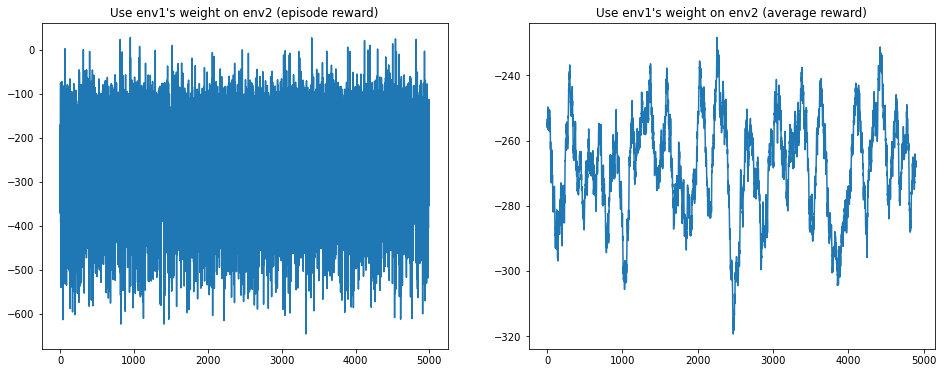

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(16, 6))

ax1.plot(ep_env1)
ax1.set_title("Use env1's weight on env2 (episode reward)")

ax2.plot(avg_env_1)
ax2.set_title("Use env1's weight on env2 (average reward)")

In [ ]:
class TNetv2(nn.Module):
    def __init__(self, teacher_1, teacher_2):
        super(TNetv2, self).__init__()
        self.t1 = teacher_1
        self.t2 = teacher_2

        self.affine = nn.Linear(256, 128)
        self.action_layer = nn.Linear(256, 4)
        self.value_layer = nn.Linear(256, 1)

        self.logprobs = []
        self.state_values = []
        self.rewards = []

    def forward(self, state):
        output_1, _ = self.t1(state)
        output_2, _ = self.t2(state)

        out = torch.cat((output_1, output_2))

        state = F.relu(out)

        action_prob = F.softmax(self.action_layer(state), dim=-1)
        state_value =  self.value_layer(state)

        distribution = Categorical(action_prob)
        action = distribution.sample()

        self.logprobs.append(distribution.log_prob(action))
        self.state_values.append(state_value)

        return action.item()
    
    def calculateLoss(self, gamma=0.99):
        
        # calculating discounted rewards:
        rewards = []
        dis_reward = 0
        for reward in self.rewards[::-1]:
            dis_reward = reward + gamma * dis_reward
            rewards.insert(0, dis_reward)
                
        # normalizing the rewards:
        rewards = torch.tensor(rewards)
        rewards = (rewards - rewards.mean()) / (rewards.std())
        
        loss = 0
        for logprob, value, reward in zip(self.logprobs, self.state_values, rewards):
            advantage = reward  - value.item()
            action_loss = -logprob * advantage
            value_loss = F.smooth_l1_loss(value, reward)
            loss += (action_loss + value_loss)   
        return loss
    
    def clearMemory(self):
        del self.logprobs[:]
        del self.state_values[:]
        del self.rewards[:]

In [ ]:
actor = torch.load('./model_weight/actor')
actor_wind = torch.load('./model_weight/actor_wind')

In [ ]:
agent5 = TNetv2(actor, actor_wind)

lr = 0.02
betas = (0.9, 0.999)
optimizer = optim.Adam(agent5.parameters(), lr=lr, betas=betas)

ep_env_5, avg_env_5, ep_env_6, avg_env_6 = train_mutitask(enviorment,env_wind, agent4, optimizer, episodes = 5000)

C:\Users\55366\AppData\Local\Temp\ipykernel_3808\1213859192.py:51: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.smooth_l1_loss(value, reward)


e: 100, episode env_1: -188.07, avg env_1: -264.03
e: 200, episode env_1: -139.83, avg env_1: -274.54
e: 300, episode env_1: -108.80, avg env_1: -253.40
e: 400, episode env_1: -373.93, avg env_1: -291.93
e: 500, episode env_1: -157.45, avg env_1: -254.77
e: 600, episode env_1: -444.30, avg env_1: -246.10
e: 700, episode env_1: -341.75, avg env_1: -267.59
e: 800, episode env_1: -377.61, avg env_1: -258.28
e: 900, episode env_1: -239.58, avg env_1: -273.56


KeyboardInterrupt: 